In [1]:
# Lets standardize some data yo!

In [18]:
import os
import zipfile
import pandas as pd

zip_path = 'experimental_data.zip'

# --- Step 1: Read Excel (only in the Jens folder) ---
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open('experimental_data/Jens/Compositions.xlsx') as f:
        df_jens_comp = pd.read_excel(f, engine='openpyxl')

# Convert the “Name” in the Excel file to lowercase for easier matching
df_jens_comp['Name_lower'] = df_jens_comp['Name'].str.lower()

# Function to map a Jens filename (e.g. “spinel1_BM31.xye”) → composition
def get_jens_composition(fname):
    # Example: “spinel1_BM31.xye” → we search “spinel1”
    # We can split off “_BM31.xye”
    # or just look for any “Name_lower” inside the file
    fname_lower = fname.lower()
    for _, row in df_jens_comp.iterrows():
        # e.g. row['Name_lower'] == “spinel1”, row['Composition'] is the formula
        if row['Name_lower'] in fname_lower:
            return row['Composition']
    # If no match found
    return None


# --- Step 2: Read in the .xy / .xye files, figure out composition ---
all_xrd_data = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for file_info in z.infolist():
        # Skip directories
        if file_info.is_dir():
            continue
        
        file_name = file_info.filename
        
        # We only care about XY or XYE
        if not (file_name.endswith('.xy') or file_name.endswith('.xye')):
            continue
        
        # Read lines
        with z.open(file_name) as f:
            lines = f.read().decode('utf-8').splitlines()
        
        # Extract folder for composition inference
        folder_path = os.path.dirname(file_name)  # e.g. “experimental_data/Jens”
        folder_name = os.path.basename(folder_path)  # e.g. “Jens”
        base_name = os.path.basename(file_name)     # e.g. “spinel1_BM31.xye”
        
        # Prepare to figure out composition:
        if folder_name.lower() == 'jens':
            # Use the Excel-based logic
            composition_str = get_jens_composition(base_name)
        
        elif folder_name.lower() == 'laura_irox':
            # Possibly parse “IrOx” or “IrO2” from the file name
            # For example: “IrO2_3nm_30minXRD.xy” → composition = “IrO2”
            # This is just an example; you can adapt the logic:
            if 'irox' in base_name.lower():
                composition_str = 'IrOx'
            elif 'iro2' in base_name.lower():
                composition_str = 'IrO2'
            else:
                composition_str = 'Ir-based oxide'
        
        elif folder_name.lower() == 'nicolas':
            # For the Nicolas data, we see subfolders: “fcc pure”, “fcc+fct”
            subfolder = file_name.split('/')[-2]  # e.g. “fcc pure” or “fcc+fct”
            if 'fcc pure' in subfolder.lower():
                composition_str = 'Pt (fcc)'
            elif 'fcc+fct' in subfolder.lower():
                composition_str = 'Pt (fcc+fct)'
            else:
                composition_str = 'Pt-based'
        
        elif folder_name.lower() == 'rebecca_ceo2':
            # For “Rebecca_CeO2”, we interpret composition as “CeO2”
            composition_str = 'CeO2'
        
        else:
            # If we have an unexpected folder, just store None or something
            composition_str = None
        
        # Parse the data lines
        records = []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                angle, intensity = parts
                records.append((float(angle), float(intensity), None))
            elif len(parts) == 3:
                angle, intensity, error = parts
                records.append((float(angle), float(intensity), float(error)))
        
        # Construct a DataFrame for this file
        df_temp = pd.DataFrame(records, columns=['angle', 'intensity', 'error'])
        df_temp['composition'] = composition_str
        df_temp['source_file'] = base_name
        df_temp['source_folder'] = folder_name
        
        all_xrd_data.append(df_temp)

# Concatenate only the valid DataFrames
df_xrd = pd.concat(filtered_frames, ignore_index=True) if filtered_frames else pd.DataFrame()

/tmp/ipykernel_2097/257249435.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xrd = pd.concat(filtered_frames, ignore_index=True) if filtered_frames else pd.DataFrame()


In [40]:
df_xrd['source_file'].unique()

array(['crystalline_CeO2_BM31.xye', 'JEP_HEO1.1_D8.xy',
       'spinel1_BM31.xye', 'spinel2_BM31.xye', 'spinel3_BM31.xye',
       'spinel4_BM31.xye', 'spinel5_BM31.xye', 'IrO2_3nm_30minXRD.xy',
       'IrO2_9nmRod_30minXRD.xy', 'IrOx_0p8nm_30minXRD.xy',
       'IrOx_1nm_30minXRD.xy', 'NS_PtHEI_300C180m.xy',
       'NS_PtHEI_300C90m.xy', 'NS_PtHEI_300C_360m_4h.xye',
       'NS_PtHEI_350C_120m.xye', 'NS_PtHEI_350C_240m.xye',
       'ESRF_IB_06_0001_2th_PtHEI.xye', 'NS_PtHEI_400C180m.xy',
       'NS_PtHEI_550C60m.xy', 'NS_PtHEI_550C_120m_4h.xye',
       'NS_PtHEI_700C_90m.xye', 'boroglass_0p8_empty_VCT_72h.xy',
       'Hydrolyse_ID10_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID5_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID6_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID8_20min_3-56_boro_0p8.xy', 'scan-4903_mean.xy',
       'scan-4907_mean.xy', 'scan-4911_mean.xy', 'scan-4912_mean.xy',
       'scan-4919_mean.xy'], dtype=object)

Jens


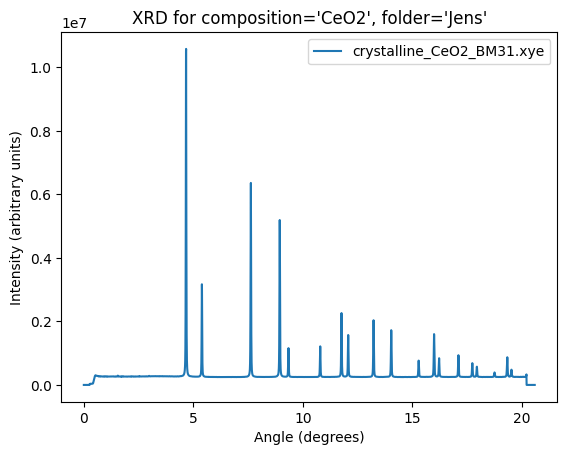

Rebecca_CeO2


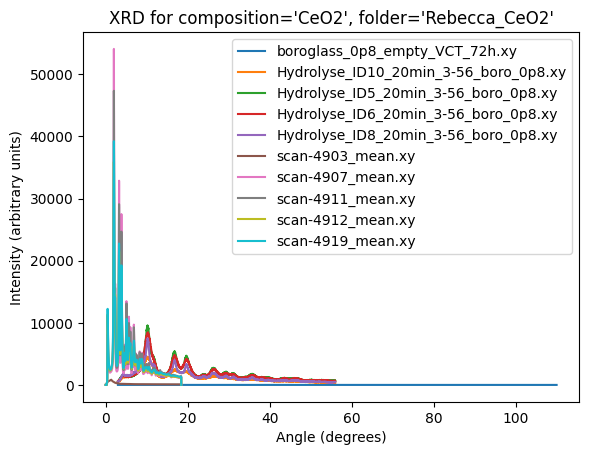

Jens


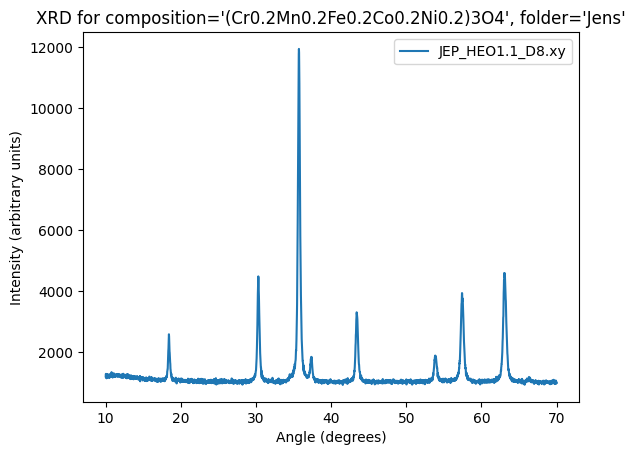

Jens


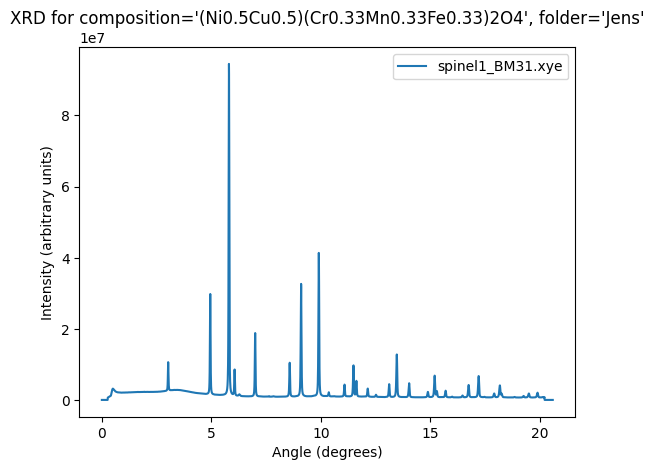

Jens


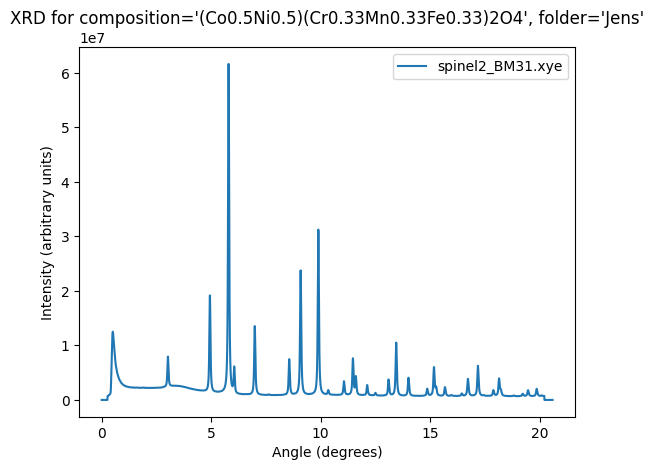

Jens


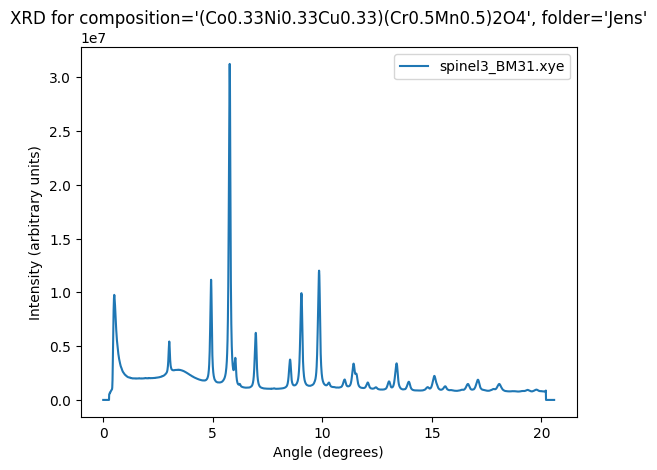

Jens


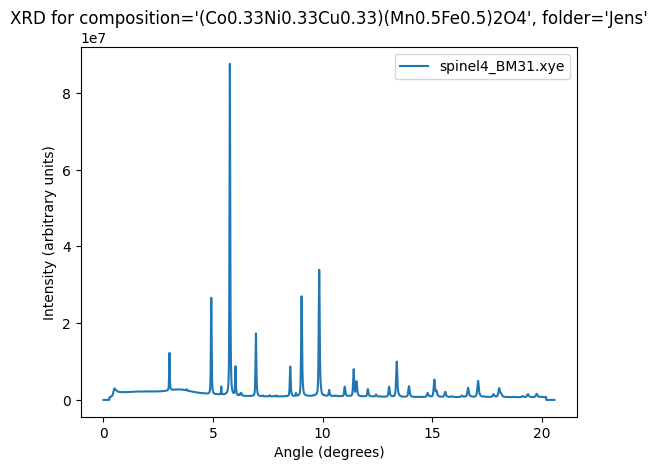

Jens


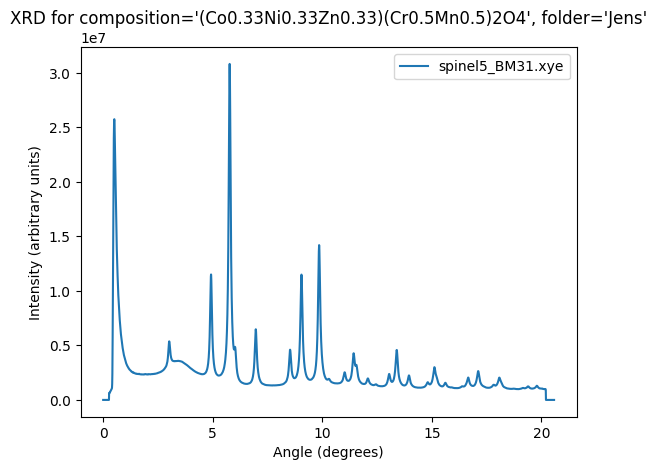

Laura_IrOx


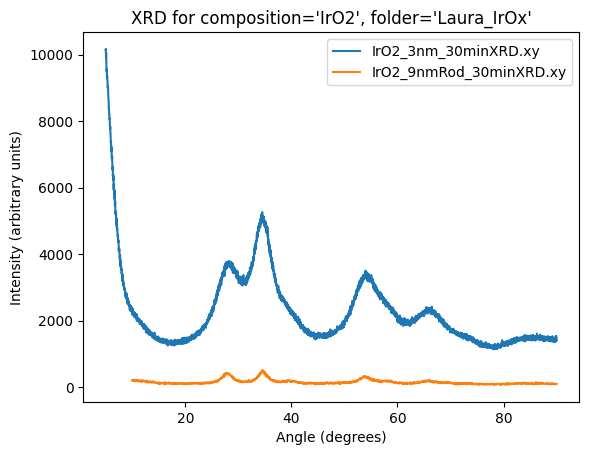

Laura_IrOx


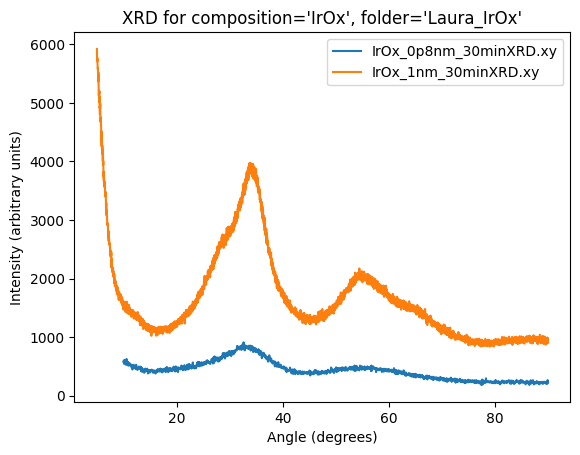

In [38]:
import matplotlib.pyplot as plt

# Extract all compositions (excluding NaN)
unique_comps = df_xrd['composition'].dropna().unique()

for comp in unique_comps:
    # Subset for this composition
    subset_comp = df_xrd[df_xrd['composition'] == comp]
    
    # For each folder in this composition, create a new figure
    for folder in subset_comp['source_folder'].unique():
        print(folder)
        subset_folder = subset_comp[subset_comp['source_folder'] == folder]
        
        # Make a distinct figure for each (composition, folder) pair
        plt.figure()
        
        # Plot each file from that composition/folder
        for sf in subset_folder['source_file'].unique():
            subset_file = subset_folder[subset_folder['source_file'] == sf]
            plt.plot(subset_file['angle'], subset_file['intensity'], label=sf)
        
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Intensity (arbitrary units)')
        plt.title(f"XRD for composition='{comp}', folder='{folder}'")
        plt.legend()
        plt.show()


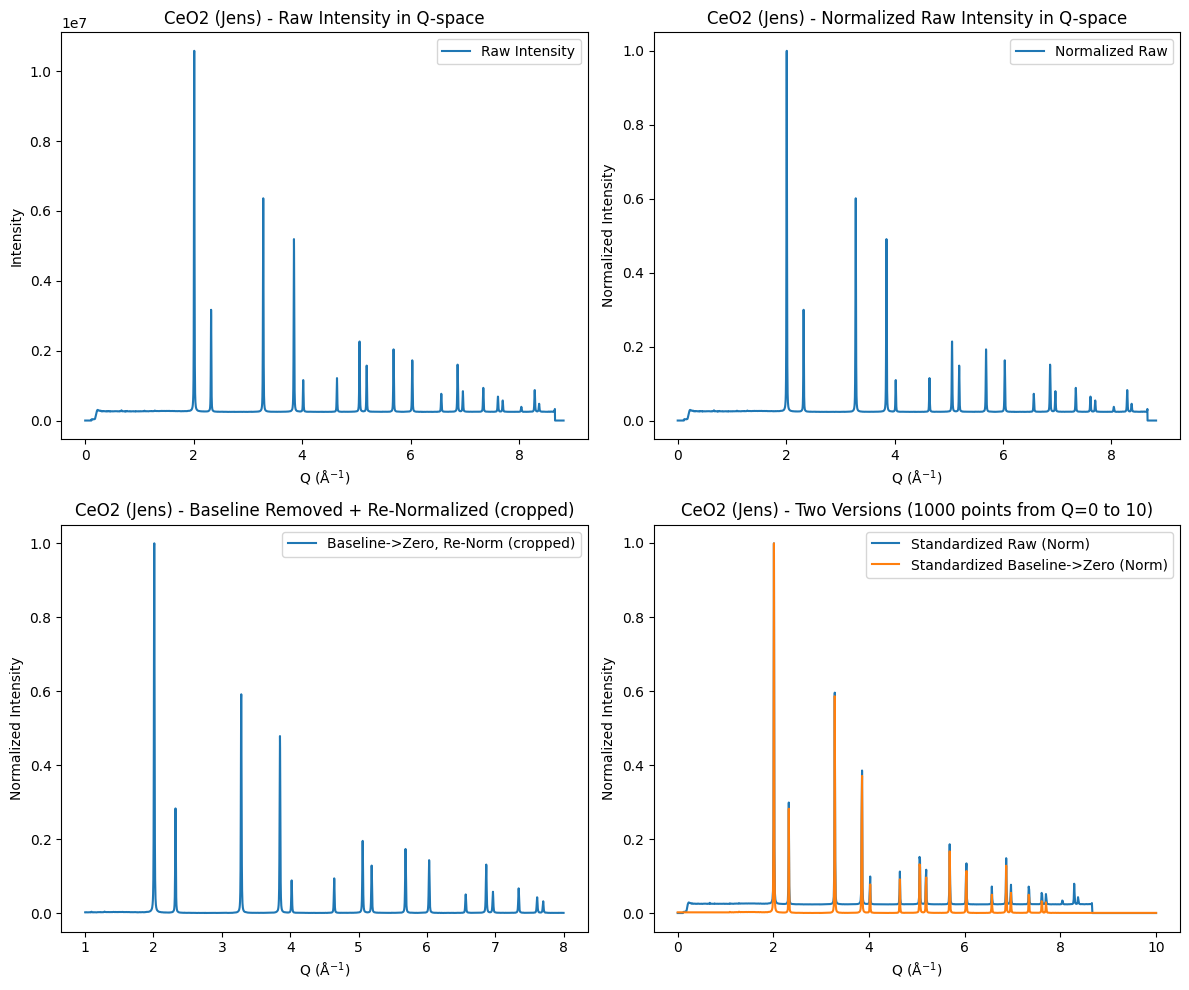

In [94]:
################################################################################
# We already have a full DataFrame (df_xrd) with all XRD data, including CeO2 from Jens.
# Now we extract only the CeO2 data from Jens, convert angle->Q, and perform the
# requested normalization, baseline steps, AND then standardize both versions
# of the signal to 1000 points from Q = 0.0 to Q = 10.0 Å.
################################################################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Filter df_xrd to get only Jens' CeO2 data
df_ceo2_jens = df_xrd[
    (df_xrd['composition'] == 'CeO2') &
    (df_xrd['source_folder'].str.lower() == 'jens')
].copy()

# 2) Convert angle (assumed to be 2θ in degrees) to Q-space
#    (Here wavelength=0.165 is what's being used. If you actually wanted Cu Ka ~1.54Å,
#     then you’d set wavelength=1.5406. But we'll keep the user’s value.)
wavelength = 0.25448
theta_rad = np.radians(df_ceo2_jens["angle"] / 2.0)  # angle is 2θ, so half of it is θ
df_ceo2_jens["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)

# 3) Step 1: Normalize the original intensity
max_intensity = df_ceo2_jens["intensity"].max(skipna=True)
df_ceo2_jens["intensity_norm"] = df_ceo2_jens["intensity"] / max_intensity

# 4) Step 2: Baseline removal (crop, shift min to zero, re-normalize)
q_min, q_max = 1.0, 8.0  # Example cropping range
df_ceo2_jens_cropped = df_ceo2_jens[
    (df_ceo2_jens["Q"] >= q_min) & (df_ceo2_jens["Q"] <= q_max)
].copy()

min_val = df_ceo2_jens_cropped["intensity"].min(skipna=True)
df_ceo2_jens_cropped["intensity_baseline_zero"] = (
    df_ceo2_jens_cropped["intensity"] - min_val
)

max_after_shift = df_ceo2_jens_cropped["intensity_baseline_zero"].max(skipna=True)
df_ceo2_jens_cropped["intensity_baseline_zero_norm"] = (
    df_ceo2_jens_cropped["intensity_baseline_zero"] / max_after_shift
)

# 5) Interpolate both versions (raw & baseline-removed) onto a
#    standard Q-grid from 0.0 to 10.0 Å^-1 with 1000 points

def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    """
    Interpolates the given `intensity_col` in DataFrame `df`
    onto a uniform Q-grid from q_min to q_max with n_points.
    Returns a new DataFrame with columns ['Q', intensity_col].
    """
    # Drop duplicates and sort by Q for safe interpolation
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)

    # Define new Q-grid
    q_new = np.linspace(q_min, q_max, n_points)
    
    # Perform interpolation
    # For Q-values outside the data range, np.interp uses boundary values
    intensity_new = np.interp(q_new, df[q_col], df[intensity_col])
    
    # Build and return a new DataFrame with the standardized grid
    return pd.DataFrame({"Q": q_new, intensity_col: intensity_new})

# 5a) Raw, normalized data => standardize from Q=0 to Q=10
df_ceo2_jens_std_raw = standardize_signal(
    df_ceo2_jens, "Q", "intensity_norm", q_min=0.0, q_max=10.0, n_points=1000
)

# 5b) Baseline-removed, re-normalized => standardize from Q=0 to Q=10
df_ceo2_jens_std_baseline = standardize_signal(
    df_ceo2_jens_cropped, "Q", "intensity_baseline_zero_norm",
    q_min=0.0, q_max=10.0, n_points=1000
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# (a) Raw intensity
axes[0].plot(df_ceo2_jens["Q"], df_ceo2_jens["intensity"], label="Raw Intensity")
axes[0].set_xlabel("Q (Å$^{-1}$)")
axes[0].set_ylabel("Intensity")
axes[0].set_title("CeO2 (Jens) - Raw Intensity in Q-space")
axes[0].legend()

# (b) Normalized raw data (original, un-cropped)
axes[1].plot(df_ceo2_jens["Q"], df_ceo2_jens["intensity_norm"], label="Normalized Raw")
axes[1].set_xlabel("Q (Å$^{-1}$)")
axes[1].set_ylabel("Normalized Intensity")
axes[1].set_title("CeO2 (Jens) - Normalized Raw Intensity in Q-space")
axes[1].legend()

# (c) Baseline-removed and re-normalized (cropped region)
axes[2].plot(
    df_ceo2_jens_cropped["Q"],
    df_ceo2_jens_cropped["intensity_baseline_zero_norm"],
    label="Baseline->Zero, Re-Norm (cropped)"
)
axes[2].set_xlabel("Q (Å$^{-1}$)")
axes[2].set_ylabel("Normalized Intensity")
axes[2].set_title("CeO2 (Jens) - Baseline Removed + Re-Normalized (cropped)")
axes[2].legend()

# (d) Standardized signals on 1000-point grid from Q=0 to Q=10
axes[3].plot(
    df_ceo2_jens_std_raw["Q"],
    df_ceo2_jens_std_raw["intensity_norm"],
    label="Standardized Raw (Norm)"
)
axes[3].plot(
    df_ceo2_jens_std_baseline["Q"],
    df_ceo2_jens_std_baseline["intensity_baseline_zero_norm"],
    label="Standardized Baseline->Zero (Norm)"
)
axes[3].set_xlabel("Q (Å$^{-1}$)")
axes[3].set_ylabel("Normalized Intensity")
axes[3].set_title("CeO2 (Jens) - Two Versions (1000 points from Q=0 to 10)")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

number of total non-trainable parameters: 26.14M
number of total trainable parameters: 27.72M
number of total conditioning MLP parameters: 0.78M


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

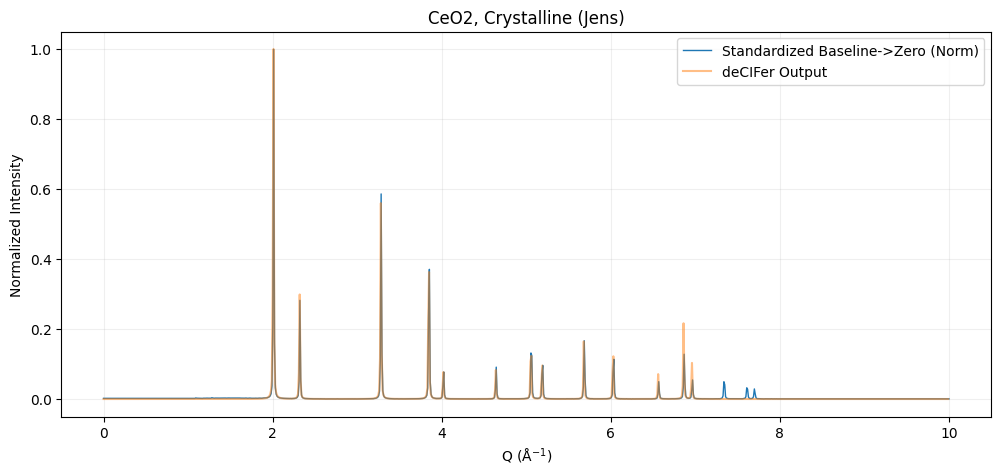

In [317]:
from bin.evaluate import load_model_from_checkpoint
from bin.train import TrainConfig
from decifer.utility import (
    pxrd_from_cif, 
    replace_symmetry_loop_with_P1, 
    extract_space_group_symbol, 
    reinstate_symmetry_loop, 
    is_formula_consistent, 
    is_space_group_consistent, 
    is_atom_site_multiplicity_consistent, 
    bond_length_reasonableness_score,
    space_group_symbol_to_number,
    space_group_to_crystal_system,
)
import crystal_toolkit
from pymatgen.core import Structure

from decifer.tokenizer import Tokenizer
import torch

from decifer.utility import pxrd_from_cif

# Define the periodic table layout (rows of 18 cells; use None for blank cells)
periodic_table_layout = [
    # Period 1
    ["H", None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, "He"],
    # Period 2
    ["Li", "Be", None, None, None, None, None, None, None, None, None, None, "B", "C", "N", "O", "F", "Ne"],
    # Period 3
    ["Na", "Mg", None, None, None, None, None, None, None, None, None, None, "Al", "Si", "P", "S", "Cl", "Ar"],
    # Period 4
    ["K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr"],
    # Period 5
    ["Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe"],
    # Period 6 Main Block
    ["Cs", "Ba", "La", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", None],
    # Period 7 Main Block
    ["Fr", "Ra", "Ac", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og", None],
    # Break
    [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    # Lanthanides (Period 6)
    [None, None, None, "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", None],
    # Actinides (Period 7)
    [None, None, None, "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", None]
]

TOKENIZER = Tokenizer()
VOCAB_SIZE = TOKENIZER.vocab_size
START_ID = TOKENIZER.token_to_id["data_"]
PADDING_ID = TOKENIZER.padding_id
NEWLINE_ID = TOKENIZER.token_to_id["\n"]
SPACEGROUP_ID = TOKENIZER.token_to_id["_symmetry_space_group_name_H-M"]
DECODE = TOKENIZER.decode
ENCODE = TOKENIZER.encode
TOKENIZE = TOKENIZER.tokenize_cif

EMPTY_BATCH_PROMPT = torch.tensor([START_ID]).unsqueeze(0).to(device=model.device)

# Build a list of all unique element symbols (default: all are selected)
inactive_elements_dict = {}
for row in periodic_table_layout:
    for el in row:
        if el is not None:
            inactive_elements_dict[el] = True

inactive_elements_dict["Ce"] = False
inactive_elements_dict["O"] = False

comp = "data_CeO\n"
comp_tokens = ENCODE(TOKENIZE(comp))
COMP_BATCH_PROMPT = torch.tensor(comp_tokens).unsqueeze(0).to(device=model.device)

# Load model
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
model = load_model_from_checkpoint(model_path, device="cuda")

# Conditioning vectors
cond_ceo2_jens_raw = torch.tensor(df_ceo2_jens_std_raw["intensity_norm"].to_numpy()).unsqueeze(0).to(device=model.device).float()
cond_ceo2_jens_baseline = torch.tensor(df_ceo2_jens_std_baseline["intensity_baseline_zero_norm"].to_numpy()).unsqueeze(0).to(device=model.device).float()

generated_batch = model.generate_custom(
    idx=EMPTY_BATCH_PROMPT,
    max_new_tokens=3000,
    cond_vec=cond_ceo2_jens_baseline,
    start_indices_batch=[[0]],
    composition_string = "Ce4O8",
    # spacegroup_string="Fm-3m_sg",
).cpu().numpy()

cif_string_gen = DECODE(generated_batch[0])
# Fix symmetry issues.
cif_string_gen = replace_symmetry_loop_with_P1(cif_string_gen)
spacegroup_symbol = extract_space_group_symbol(cif_string_gen)
if spacegroup_symbol != "P 1":
    cif_string_gen = reinstate_symmetry_loop(cif_string_gen, spacegroup_symbol)

structure_gen = Structure.from_str(cif_string_gen, fmt="cif")

pxrd_out = pxrd_from_cif(cif_string_gen, base_fwhm=0.0125)
fig = plt.figure(figsize=(12,5))

plt.plot(
    df_ceo2_jens_std_baseline["Q"],
    df_ceo2_jens_std_baseline["intensity_baseline_zero_norm"],
    label="Standardized Baseline->Zero (Norm)",
    lw=1,
)
plt.plot(pxrd_out["q"], pxrd_out["iq"], alpha=0.5, label='deCIFer Output')

plt.grid(alpha=0.2)
plt.legend()
plt.xlabel("Q (Å$^{-1}$)")
plt.ylabel("Normalized Intensity")
plt.title("CeO2, Crystalline (Jens)")
plt.show()


number of total non-trainable parameters: 26.14M
number of total trainable parameters: 27.72M
number of total conditioning MLP parameters: 0.78M


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

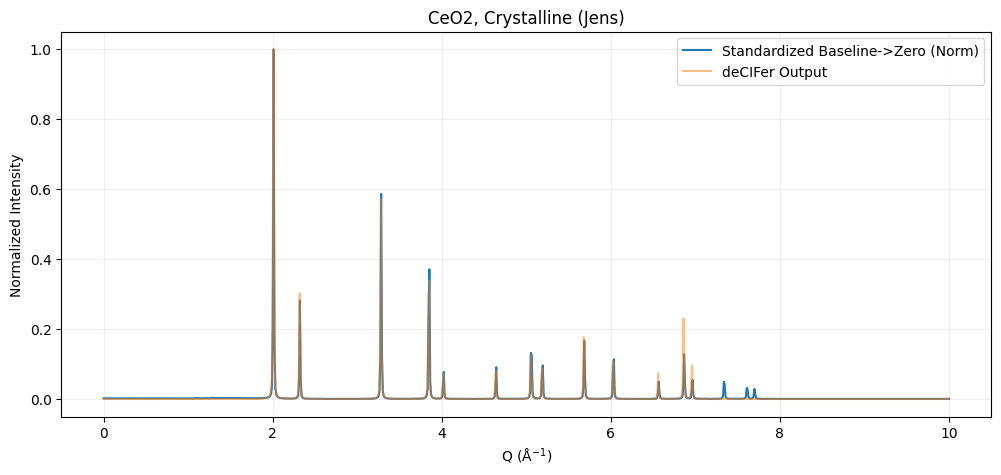

In [319]:
import torch
import matplotlib.pyplot as plt

from bin.evaluate import load_model_from_checkpoint
from decifer.tokenizer import Tokenizer
from decifer.utility import (
    pxrd_from_cif, 
    replace_symmetry_loop_with_P1, 
    extract_space_group_symbol, 
    reinstate_symmetry_loop,
)
from pymatgen.core import Structure

# Initialize tokenizer
TOKENIZER = Tokenizer()
START_ID = TOKENIZER.token_to_id["data_"]

# Create empty batch prompt
EMPTY_BATCH_PROMPT = torch.tensor([START_ID]).unsqueeze(0).cuda()

# Load model
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
model = load_model_from_checkpoint(model_path, device="cuda")

# Example conditioning vector (replace df_ceo2_jens_std_baseline with your actual DataFrame)
cond_ceo2_jens_baseline = torch.tensor(
    df_ceo2_jens_std_baseline["intensity_baseline_zero_norm"].to_numpy()
).unsqueeze(0).float().cuda()

# Generate CIF
generated_batch = model.generate_custom(
    idx=EMPTY_BATCH_PROMPT,
    max_new_tokens=3000,
    cond_vec=cond_ceo2_jens_baseline,
    start_indices_batch=[[0]],
    composition_string="Ce4O8",
).cpu().numpy()

# Decode and fix symmetry
cif_string_gen = TOKENIZER.decode(generated_batch[0])
cif_string_gen = replace_symmetry_loop_with_P1(cif_string_gen)
spacegroup_symbol = extract_space_group_symbol(cif_string_gen)
if spacegroup_symbol != "P 1":
    cif_string_gen = reinstate_symmetry_loop(cif_string_gen, spacegroup_symbol)

# Convert to pymatgen Structure
structure_gen = Structure.from_str(cif_string_gen, fmt="cif")

# PXRD
pxrd_out = pxrd_from_cif(cif_string_gen, base_fwhm=0.0125)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_ceo2_jens_std_baseline["Q"], 
         df_ceo2_jens_std_baseline["intensity_baseline_zero_norm"],
         label="Standardized Baseline->Zero (Norm)")
plt.plot(pxrd_out["q"], pxrd_out["iq"], alpha=0.5, label="deCIFer Output")
plt.grid(alpha=0.2)
plt.legend()
plt.xlabel("Q (Å$^{-1}$)")
plt.ylabel("Normalized Intensity")
plt.title("CeO2, Crystalline (Jens)")
plt.show()


number of total non-trainable parameters: 26.14M
number of total trainable parameters: 27.72M
number of total conditioning MLP parameters: 0.78M


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

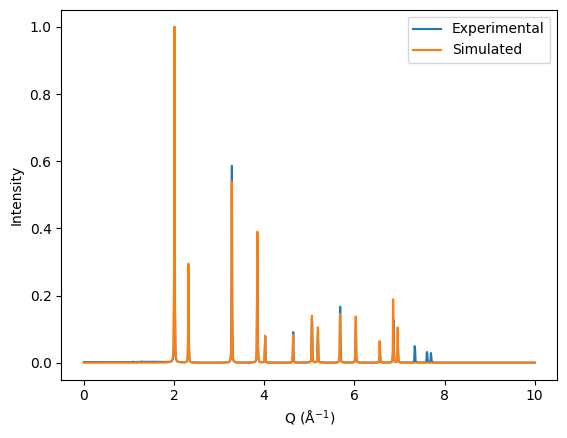

In [367]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pymatgen.core import Structure
from IPython.display import display

# Minimal imports from your modules (adjust paths as needed):
from bin.evaluate import load_model_from_checkpoint
from decifer.tokenizer import Tokenizer
from decifer.utility import (
    pxrd_from_cif,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop
)

###############################################################################
# Data parsing
###############################################################################
def read_experimental_data(zip_path):
    """
    Reads and combines all .xy or .xye files in the zip,
    maps them to their compositions, returns a single DataFrame.
    """
    # Read Jens composition Excel
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open('experimental_data/Jens/Compositions.xlsx') as f:
            df_jens_comp = pd.read_excel(f, engine='openpyxl')
    df_jens_comp['Name_lower'] = df_jens_comp['Name'].str.lower()
    
    def get_jens_composition(fname):
        fname_lower = fname.lower()
        for _, row in df_jens_comp.iterrows():
            if row['Name_lower'] in fname_lower:
                return row['Composition']
        return None
    
    frames = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for info in z.infolist():
            if info.is_dir():
                continue
            fn = info.filename
            if not (fn.endswith('.xy') or fn.endswith('.xye')):
                continue
            
            with z.open(fn) as f:
                lines = f.read().decode('utf-8').splitlines()
            
            folder = os.path.basename(os.path.dirname(fn))
            base_name = os.path.basename(fn)
            # Infer composition
            if folder.lower() == 'jens':
                comp_str = get_jens_composition(base_name)
            elif folder.lower() == 'laura_irox':
                if 'irox' in base_name.lower():
                    comp_str = 'IrOx'
                elif 'iro2' in base_name.lower():
                    comp_str = 'IrO2'
                else:
                    comp_str = 'Ir-based oxide'
            elif folder.lower() == 'nicolas':
                subfolder = fn.split('/')[-2]
                if 'fcc pure' in subfolder.lower():
                    comp_str = 'Pt (fcc)'
                elif 'fcc+fct' in subfolder.lower():
                    comp_str = 'Pt (fcc+fct)'
                else:
                    comp_str = 'Pt-based'
            elif folder.lower() == 'rebecca_ceo2':
                comp_str = 'CeO2'
            else:
                comp_str = None

            records = []
            for line in lines:
                parts = line.split()
                if len(parts) == 2:
                    angle, intensity = parts
                    records.append((float(angle), float(intensity), None))
                elif len(parts) == 3:
                    angle, intensity, error = parts
                    records.append((float(angle), float(intensity), float(error)))

            df_temp = pd.DataFrame(records, columns=['angle', 'intensity', 'error'])
            df_temp['composition'] = comp_str
            df_temp['source_file'] = base_name
            df_temp['source_folder'] = folder
            frames.append(df_temp)

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

###############################################################################
# Preprocessing for CeO2 from Jens
###############################################################################
def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
    q_new = np.linspace(q_min, q_max, n_points)
    i_new = np.interp(q_new, df[q_col], df[intensity_col])
    return pd.DataFrame({"Q": q_new, intensity_col: i_new})

def preprocess_ceo2_jens(df_xrd, wavelength=0.25448, q_min_crop=1.0, q_max_crop=8.0):
    df_ceo2 = df_xrd[
        (df_xrd['composition'] == 'CeO2') & 
        (df_xrd['source_folder'].str.lower() == 'jens')
    ].copy()
    theta_rad = np.radians(df_ceo2["angle"] / 2.0)
    df_ceo2["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)
    maxI = df_ceo2["intensity"].max(skipna=True)
    df_ceo2["intensity_norm"] = df_ceo2["intensity"] / maxI

    df_crop = df_ceo2[
        (df_ceo2["Q"] >= q_min_crop) & (df_ceo2["Q"] <= q_max_crop)
    ].copy()
    min_val = df_crop["intensity"].min(skipna=True)
    df_crop["intensity_baseline_zero"] = df_crop["intensity"] - min_val
    max_shift = df_crop["intensity_baseline_zero"].max(skipna=True)
    df_crop["intensity_baseline_zero_norm"] = df_crop["intensity_baseline_zero"] / max_shift
    
    df_std_raw = standardize_signal(df_ceo2, "Q", "intensity_norm")
    df_std_base = standardize_signal(df_crop, "Q", "intensity_baseline_zero_norm")
    return df_ceo2, df_crop, df_std_raw, df_std_base

###############################################################################
# deCIFer model pipeline
###############################################################################
TOKENIZER = Tokenizer()
START_ID = TOKENIZER.token_to_id["data_"]
ENCODE = TOKENIZER.encode
TOKENIZE = TOKENIZER.tokenize_cif
DECODE = TOKENIZER.decode

def load_custom_model(model_path, device="cuda"):
    return load_model_from_checkpoint(model_path, device=device)

def fix_symmetry_in_cif(cif_string):
    c = replace_symmetry_loop_with_P1(cif_string)
    sg = extract_space_group_symbol(c)
    return reinstate_symmetry_loop(c, sg) if sg != "P 1" else c

def generate_cif(model, cond_vec, composition=None, spacegroup=None, max_new_tokens=3000):
    prompt = torch.tensor([START_ID]).unsqueeze(0).to(model.device)
    if composition:
        comp_str = f"data_{composition}\n"
        c_tokens = ENCODE(TOKENIZE(comp_str))
        prompt = torch.tensor(c_tokens).unsqueeze(0).to(model.device)
    out = model.generate_custom(
        idx=prompt,
        max_new_tokens=max_new_tokens,
        cond_vec=cond_vec,
        start_indices_batch=[[0]],
        composition_string=composition,
        spacegroup_string=spacegroup
    ).cpu().numpy()
    return DECODE(out[0])

def run_decifer_generation(model_path, cond_array, composition=None, spacegroup=None,
                           device="cuda", do_plot=False, q_exp=None, i_exp=None):
    model = load_custom_model(model_path, device=device)
    if not isinstance(cond_array, torch.Tensor):
        cond_array = torch.tensor(cond_array)
    cond_array = cond_array.unsqueeze(0).to(model.device).float()

    cif_raw = generate_cif(model, cond_vec=cond_array, composition=composition, spacegroup=spacegroup)
    cif_fixed = fix_symmetry_in_cif(cif_raw)
    structure = Structure.from_str(cif_fixed, fmt="cif")
    pxrd_dict = pxrd_from_cif(cif_fixed, base_fwhm=0.0125)

    if do_plot and (q_exp is not None) and (i_exp is not None):
        plt.plot(q_exp, i_exp, label="Experimental")
        plt.plot(pxrd_dict["q"], pxrd_dict["iq"], label="Simulated")
        plt.xlabel("Q (Å$^{-1}$)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()
        display(structure)

    return cif_fixed, structure, pxrd_dict

# Adjust as needed:
zip_path = "experimental_data.zip"
df_all = read_experimental_data(zip_path)

df_ceo2, df_ceo2_crop, df_ceo2_std_raw, df_ceo2_std_base = preprocess_ceo2_jens(df_all)
# Example condition vector for deCIFer
cond_ceo2_baseline = df_ceo2_std_base["intensity_baseline_zero_norm"].values

# If you have a trained model checkpoint:
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
cif_str, struct, pxrd_out = run_decifer_generation(
    model_path=model_path,
    cond_array=cond_ceo2_baseline,
    composition="Ce4O8",
    spacegroup=None,
    device="cuda",
    do_plot=True,
    q_exp=df_ceo2_std_base["Q"].values,
    i_exp=df_ceo2_std_base["intensity_baseline_zero_norm"].values
)

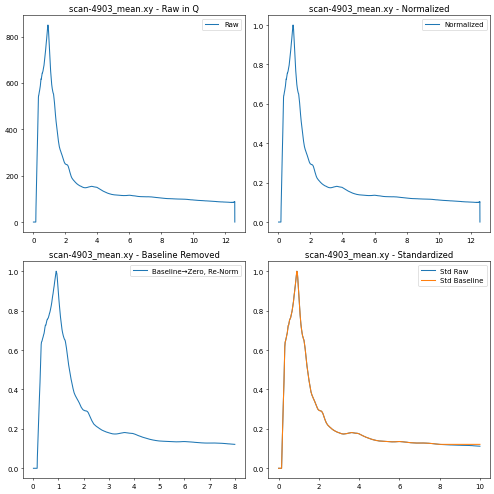

number of total non-trainable parameters: 26.14M
number of total trainable parameters: 27.72M
number of total conditioning MLP parameters: 0.78M


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

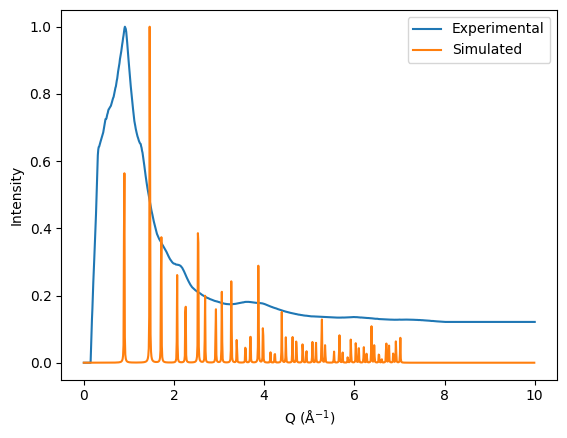

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_generic(df, target_file, 
                       wavelength=0.25448, q_min_crop=1.0, q_max_crop=8.0,
                       n_points=1000):
    # Filter
    df_sel = df[
        (df['source_file'].str.lower() == target_file.lower())
    ].copy()

    # Convert angle → Q
    theta_rad = np.radians(df_sel["angle"] / 2.0)
    df_sel["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)

    # Normalize
    maxI = df_sel["intensity"].max(skipna=True)
    df_sel["intensity_norm"] = df_sel["intensity"] / maxI

    # Crop for baseline removal
    df_crop = df_sel[
        (df_sel["Q"] >= q_min_crop) & (df_sel["Q"] <= q_max_crop)
    ].copy()
    min_val = df_crop["intensity"].min(skipna=True)
    df_crop["intensity_baseline_zero"] = df_crop["intensity"] - min_val
    max_shift = df_crop["intensity_baseline_zero"].max(skipna=True)
    df_crop["intensity_baseline_zero_norm"] = df_crop["intensity_baseline_zero"] / max_shift
    
    # Standardize signals
    df_std_raw = standardize_signal(df_sel, "Q", "intensity_norm",
                                    q_min=0.0, q_max=10.0, n_points=n_points)
    df_std_base = standardize_signal(df_crop, "Q", "intensity_baseline_zero_norm",
                                     q_min=0.0, q_max=10.0, n_points=n_points)

    return df_sel, df_crop, df_std_raw, df_std_base

def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
    q_new = np.linspace(q_min, q_max, n_points)
    i_new = np.interp(q_new, df[q_col], df[intensity_col])
    return pd.DataFrame({q_col: q_new, intensity_col: i_new})

target_file = 'scan-4903_mean.xy'

# Example usage for IrOx in 'Laura_IrOx' folder
df_sample, df_sample_crop, df_sample_std_raw, df_sample_std_base = preprocess_generic(
    df_all,
    target_file=target_file,
    wavelength=0.16,  # or your chosen wavelength
    q_min_crop=0.0, 
    q_max_crop=8.0
)

# Now df_irox, df_irox_crop, etc. contain the processed IrOx data.
# Plotting example:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

axes[0].plot(df_sample["Q"], df_sample["intensity"], label="Raw")
axes[0].set_title(f"{target_file} - Raw in Q")
axes[1].plot(df_sample["Q"], df_sample["intensity_norm"], label="Normalized")
axes[1].set_title(f"{target_file} - Normalized")

axes[2].plot(df_sample_crop["Q"], df_sample_crop["intensity_baseline_zero_norm"], label="Baseline→Zero, Re-Norm")
axes[2].set_title(f"{target_file} - Baseline Removed")

axes[3].plot(df_sample_std_raw["Q"], df_sample_std_raw["intensity_norm"], label="Std Raw")
axes[3].plot(df_sample_std_base["Q"], df_sample_std_base["intensity_baseline_zero_norm"], label="Std Baseline")
axes[3].set_title(f"{target_file} - Standardized")

for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

# If you have a trained model checkpoint:
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
cif_str, struct, pxrd_out = run_decifer_generation(
    model_path=model_path,
    cond_array=df_sample_std_base["intensity_baseline_zero_norm"].values,
    composition="Ce4O8",
    # spacegroup=None,
    device="cuda",
    do_plot=True,
    q_exp=df_sample_std_base["Q"].values,
    i_exp=df_sample_std_base["intensity_baseline_zero_norm"].values
)